# Heart Failure Prediction - IA01 Project Autumn 2025
# UTT - Introduction to Artificial Intelligence
 
This notebook contains the exploratory data analysis, data preprocessing, 
and machine learning modeling steps for predicting heart failure. 
The dataset used combines multiple sources including Cleveland, Hungarian, 
Switzerland, Long Beach VA, and Stalog datasets, resulting in 918 observations 
after removing duplicates.

The goal is to analyze the dataset, identify important features, 
train several classification models (kNN, Decision Tree, Random Forest, 
Logistic Regression, Neural Networks), and evaluate their performance.


# Helpers

In [44]:
def hist_box(feature, data):
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    sns.histplot(x=feature, data=data)
    plt.subplot(1,2,2)
    sns.boxplot(y=feature, data=data)
    plt.tight_layout()
    plt.show()

In [45]:
def IQR(feature, data):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# We import important libraries to analyze the dataset
 

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer

# EDA

## Dataset Loading & Basic Structure

In [47]:
heart_data = pd.read_csv('../data/heart.csv')
print(f"In our dataset we have {heart_data.shape[0]} rows and {heart_data.shape[1]} columns")
print(heart_data.head())

In our dataset we have 918 rows and 12 columns
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [48]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Check for Missing Values

In [49]:
heart_data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [50]:
heart_data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

The dataset **doesn't** contains `NaN` or `Null` values

## Descriptive Statistics (Numeric)

In [51]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


The dataset contains 918 samples with seven numerical features, including the target variable `HeartDisease`. Age ranges from **28 to 77 years** (mean **≈ 53.5**), indicating a predominantly middle-aged population, which is typical for heart disease studies. Resting blood pressure (**RestingBP**) has an average of 132 mmHg with values ranging from 0 to 200; the minimum value of 0 mmHg is physiologically impossible and therefore corresponds to erroneous or missing measurements that **must be corrected during preprocessing**. Similarly, Cholesterol shows a wide range from 0 to 603 mg/dl, with a mean of about 199 mg/dl. The presence of 0 mg/dl again indicates *invalid* entries that should be treated as missing data.

FastingBS is a binary indicator (0 or 1), which explains its mean of **0.23** and quartiles at **0**. MaxHR ranges from **60 to 202** bpm, with an average of about **137** bpm, reflecting substantial variability in patients’ exercise capacities. Oldpeak (ST depression) spans from **–2.6 to 6.2**, suggesting both normal and abnormal ECG responses to exercise and a right-skewed distribution due to higher positive values.

The target variable `HeartDisease` is binary (0 = no heart disease, 1 = heart disease) with a mean of approximately 0.55 and a median and upper quartile equal to 1. This indicates that a bit **more than half of the patients in the dataset are labeled as having heart disease**, so the classes are not perfectly balanced but also not extremely imbalanced.

Overall, the descriptive statistics reveal
  - invalid zero values in some medical measurements (RestingBP, Cholesterol),
  - skewed distributions for certain features
  - a moderate prevalence of heart disease, all of which must be taken into account in the subsequent preprocessing and modeling steps.

## Univariate Analysis — Numeric Features

In [52]:
numeric_features = heart_data.select_dtypes(include='number').columns.tolist()

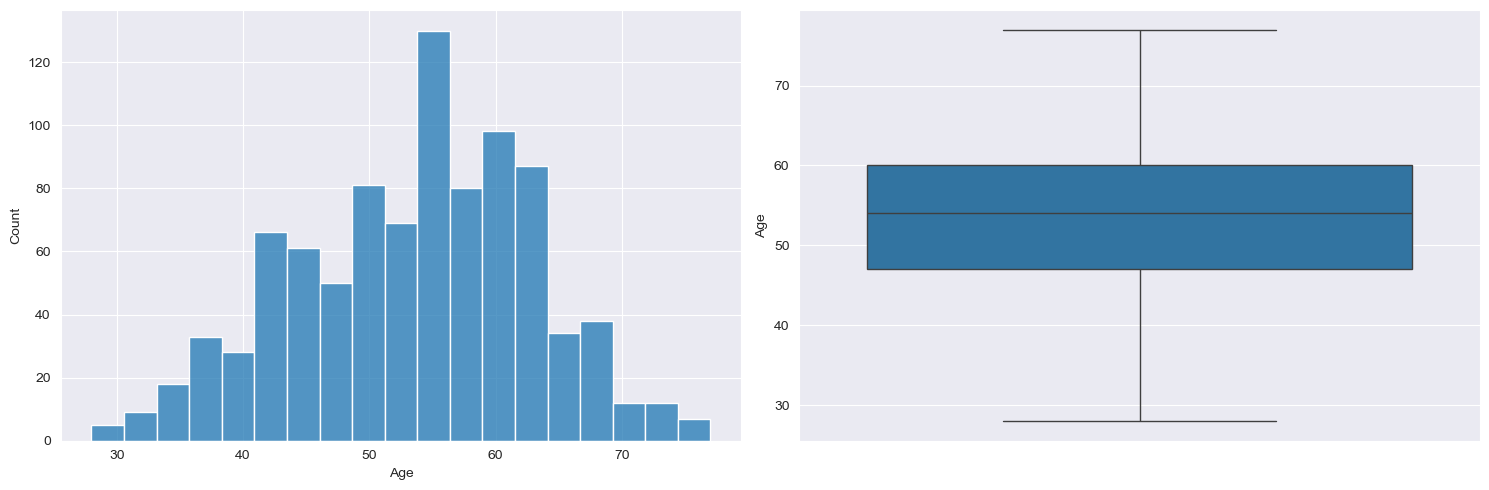

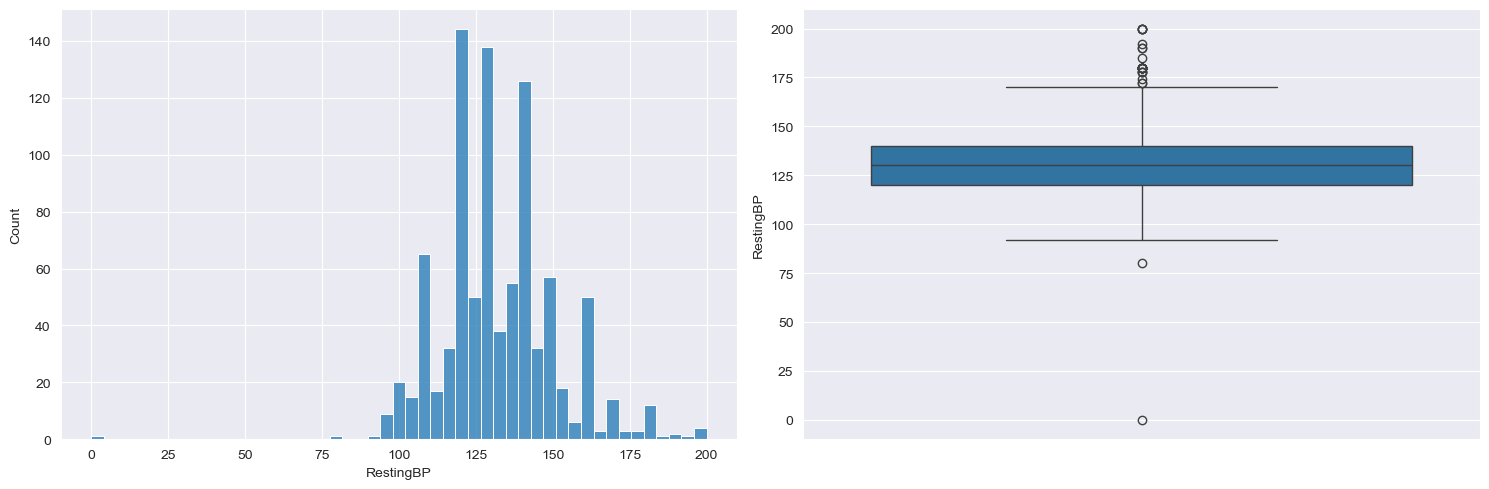

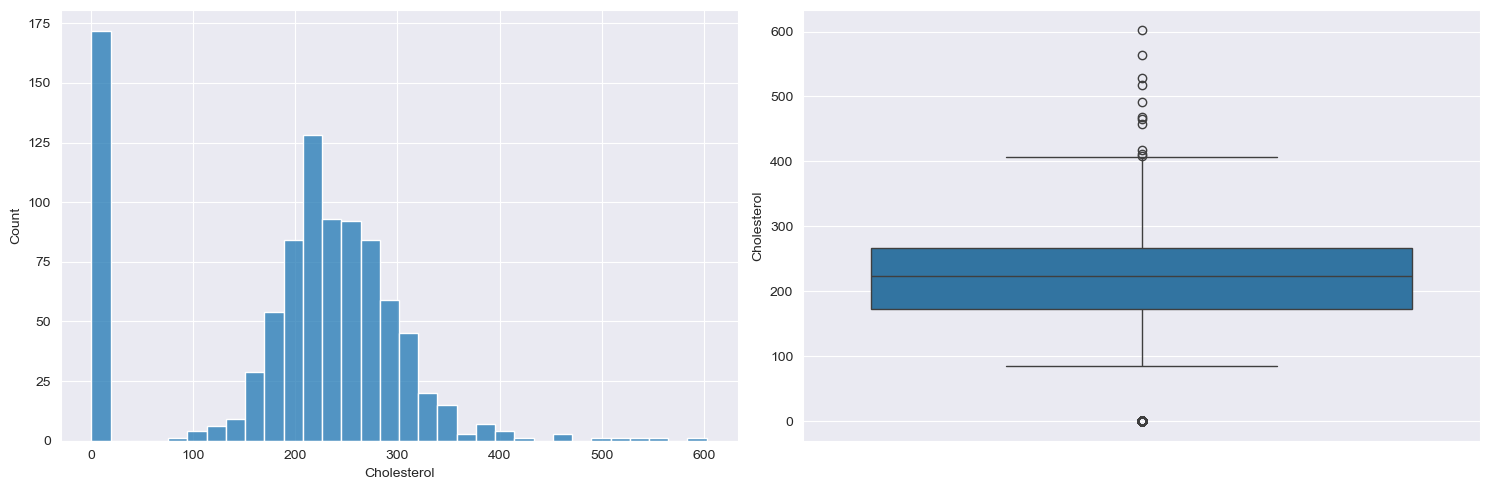

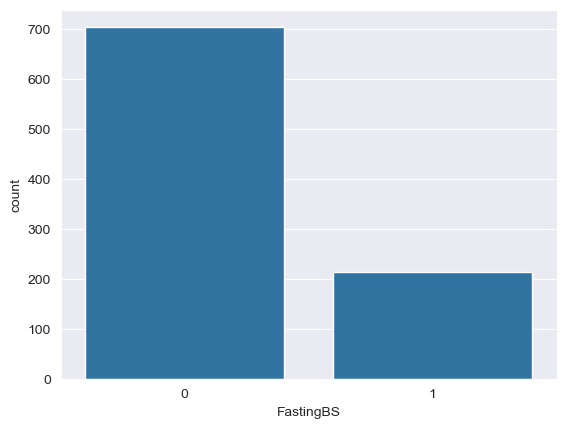

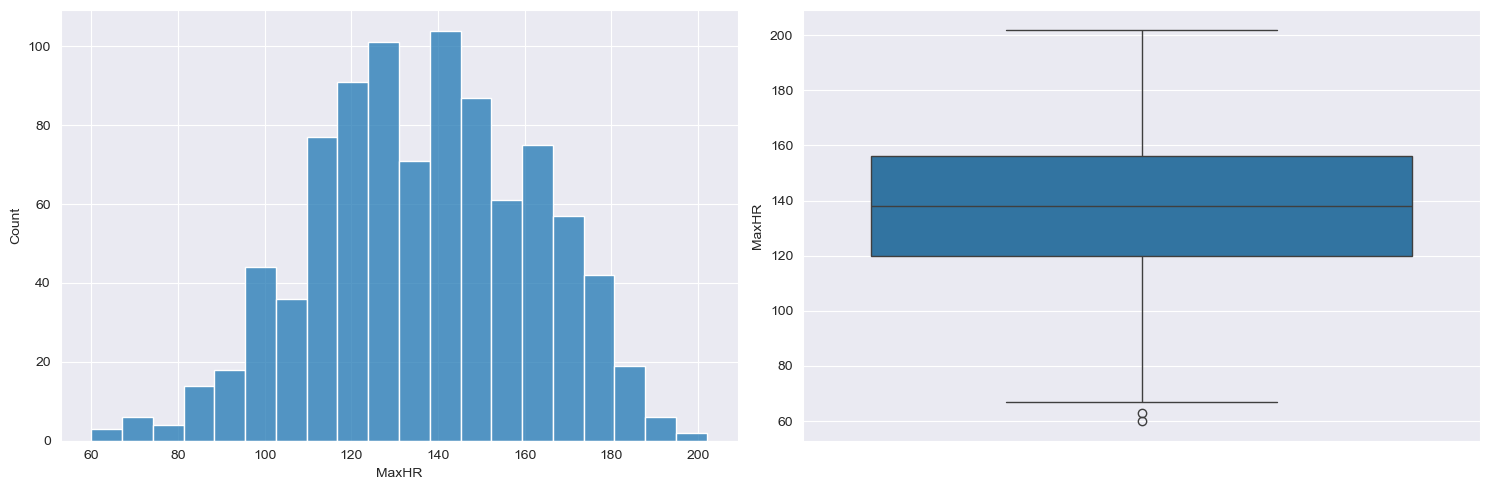

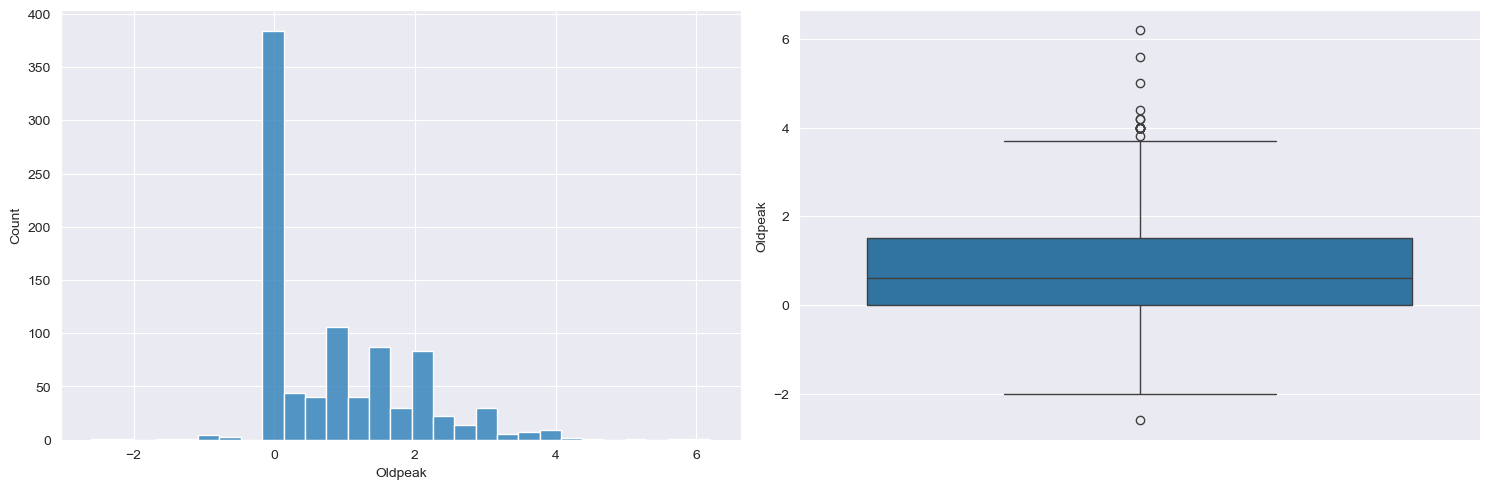

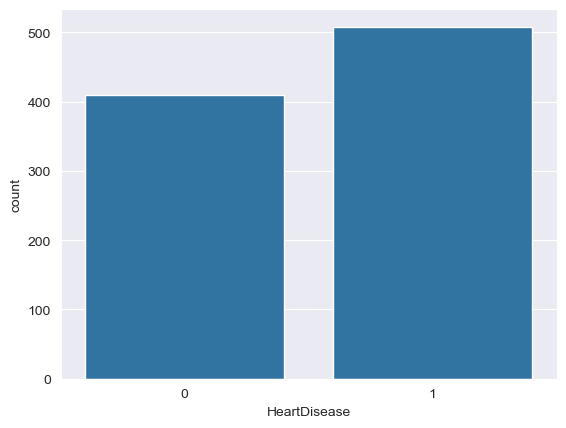

In [53]:
for feature in numeric_features:
    if feature in ['FastingBS', "HeartDisease"]:
        sns.countplot(x=feature, data=heart_data)
    else:
        hist_box(feature, heart_data)

- `Age`
    - The histogram shows that Age is approximately normally distributed, with most patients between **45 and 65 years old**, which is typical for a heart-disease-focused dataset. The boxplot indicates a relatively symmetric distribution with no extreme outliers, suggesting that Age is a clean and reliable feature. Overall, the population is predominantly middle-aged to older adults, aligning with known risk groups for heart disease.
- `RestingBP`
    - The histogram for RestingBP shows a roughly centered distribution around **120–140 mmHg**, which is consistent with typical resting blood pressure ranges in adults. A single value at **0 mmHg** appears in both the histogram and boxplot, which is physiologically impossible and indicates an erroneous or missing measurement. The boxplot also reveals several high outliers above **170 mmHg**, likely representing hypertensive patients rather than data errors.
- `Choresterol`
    - The histogram shows a large spike at **0 mg/dl**, which is medically impossible and indicates erroneous or missing cholesterol values that must be corrected. Among valid measurements, cholesterol follows a right-skewed distribution centered around **200–260 mg/dl**, with several high outliers above **400 mg/dl**. The boxplot confirms both the invalid zero values and the presence of clinically plausible high-cholesterol outliers.
- `FastingBS`
    - The bar plot shows that most patients have a fasting blood sugar value of **0**, meaning normal glucose levels, while a smaller portion (around 20–25%) have elevated fasting blood sugar (value **1**). This reflects the expected distribution in a general or clinical population, where high fasting sugar is less common. Because FastingBS is a binary variable, no outliers or unusual patterns are present.
- `MaxHR`
    - The histogram shows that MaxHR is mostly concentrated between **120 and 160 bpm**, forming an approximately bell-shaped distribution typical for exercise stress testing. A small number of very low values, such as **60 bpm**, appear in the boxplot and represent unusual or clinically concerning cases, possibly due to incomplete exercise tests or severe cardiac limitations. Overall, the feature looks clean but contains a few physiologically extreme low outliers worth noting.
- `Oldpeak`
    - The histogram shows that Oldpeak is heavily right-skewed, with the majority of values clustered at 0, indicating no ST depression during exercise, while higher values up to **6** represent more severe abnormalities. The boxplot highlights several high outliers above **4**, which likely correspond to patients with significant cardiac stress responses. A few negative values also appear, which can occur due to ECG baseline shifts, but they remain rare and should be kept in mind during preprocessing.
- `HeartDisease`
    - The target variable is fairly balanced, with slightly more patients labeled as having heart disease **(1)** than not **(0)**. This moderate class imbalance should not cause major issues during model training but may still benefit from stratified train–test splitting. Overall, the distribution indicates that the dataset contains sufficient examples of both classes for effective classification modeling.

## Detect and Handle Invalid Values (Zeros in Medical Data)

### RestingBP

In [54]:
lower, upper = IQR('RestingBP', heart_data)
heart_data[(heart_data['RestingBP'] < lower) | (heart_data['RestingBP'] > upper)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
109,39,M,ATA,190,241,0,Normal,106,N,0.0,Up,0
123,58,F,ATA,180,393,0,Normal,110,Y,1.0,Flat,1
189,53,M,ASY,180,285,0,ST,120,Y,1.5,Flat,1
190,46,M,ASY,180,280,0,ST,120,N,0.0,Up,0
241,54,M,ASY,200,198,0,Normal,142,Y,2.0,Flat,1
274,45,F,ATA,180,295,0,Normal,180,N,0.0,Up,0
275,59,M,NAP,180,213,0,Normal,100,N,0.0,Up,0
278,57,F,ASY,180,347,0,ST,126,Y,0.8,Flat,0
314,53,M,ASY,80,0,0,Normal,141,Y,2.0,Down,0
365,64,F,ASY,200,0,0,Normal,140,Y,1.0,Flat,1


In [55]:
df_eda = heart_data.copy()
df_eda['RestingBP'] = df_eda['RestingBP'].replace(0, np.nan)
median_bp = df_eda['RestingBP'].median()
df_eda['RestingBP'] = df_eda['RestingBP'].fillna(median_bp)

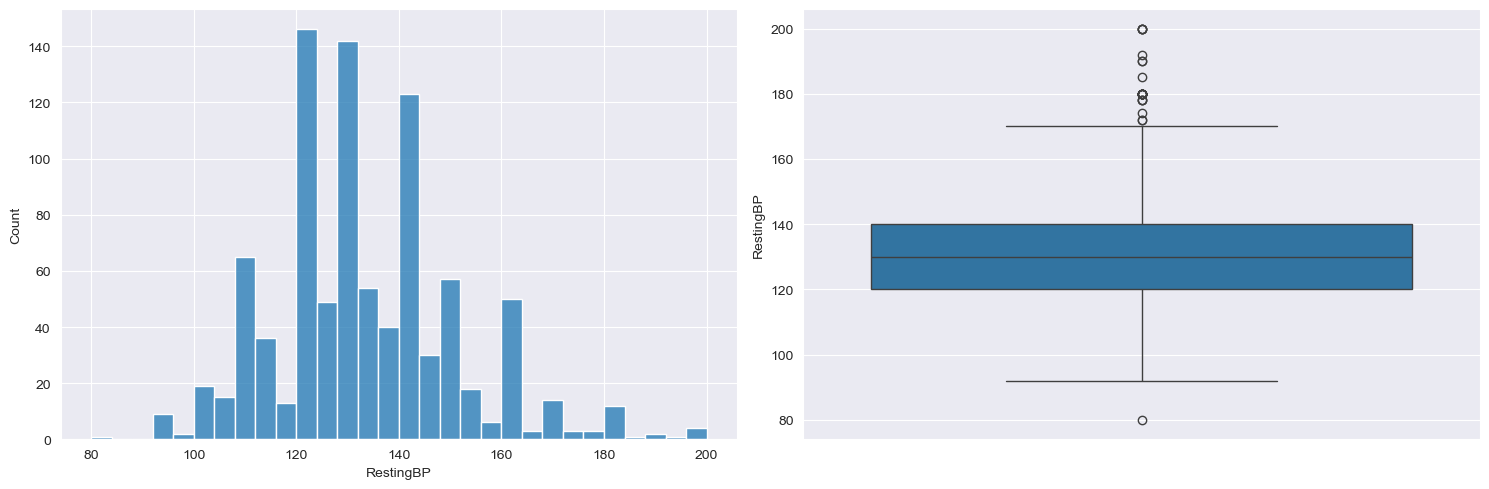

In [56]:
hist_box("RestingBP", df_eda)

#### Analysis of `RestingBP` (Resting Blood Pressure)

1.  **Initial Statistical Look:** The initial `describe()` and plots revealed a critical data error: a `min` value of **0**. This is a non-physical, impossible value for blood pressure and likely represents a placeholder for missing data.
2.  **IQR Analysis:** An IQR analysis confirmed that `0` was a statistical outlier. It also flagged many high values (e.g., `> 170`) and a few low-but-possible values (e.g., `80`).
3.  **Domain Knowledge Check & Decision:**
    * **The `0` value:** This is a **data error ("trash")** that must be fixed. Leaving it would skew all analysis (mean, correlations).
    * **The high values (`> 170`):** These are **not errors**. They represent severe hypertension and are **critical data points ("treasure")** for a heart disease model.
    * **The low value (`80`):** This is also **not an error**. It represents hypotension and is a valid clinical observation.
4.  **Action Taken:**
    * The cleaning was **highly targeted**. We did *not* blindly remove all IQR outliers.
    * Only the impossible `0` value was replaced with `np.nan`.
    * These `NaN` values were then imputed with the dataset's **median**. The median was chosen over the mean as it is robust to the other valid high-value outliers.
5.  **Conclusion:** The "after" plots confirm the `0` anomaly is gone. The data is now clean, with all clinically significant, real outliers (`80`, `180`, `200`, etc.) correctly preserved for analysis.

### Cholesterol

In [57]:
lower, upper = IQR('Cholesterol', heart_data)
heart_data[(heart_data['Cholesterol'] < lower) | (heart_data['Cholesterol'] > upper)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
28,53,F,ATA,113,468,0,Normal,127,N,0.0,Up,0
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
69,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0
76,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1
103,40,M,ASY,120,466,1,Normal,152,Y,1.0,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1
536,62,M,NAP,133,0,1,ST,119,Y,1.2,Flat,1
616,67,F,NAP,115,564,0,LVH,160,N,1.6,Flat,0
667,65,F,NAP,140,417,1,LVH,157,N,0.8,Up,0


In [58]:
(heart_data['Cholesterol']==0).sum()

172

In [59]:
df_eda["Cholesterol"] = df_eda["Cholesterol"].replace(0, np.nan)
median_cholesterol = df_eda["Cholesterol"].median()
df_eda["Cholesterol"] = df_eda["Cholesterol"].fillna(median_cholesterol)

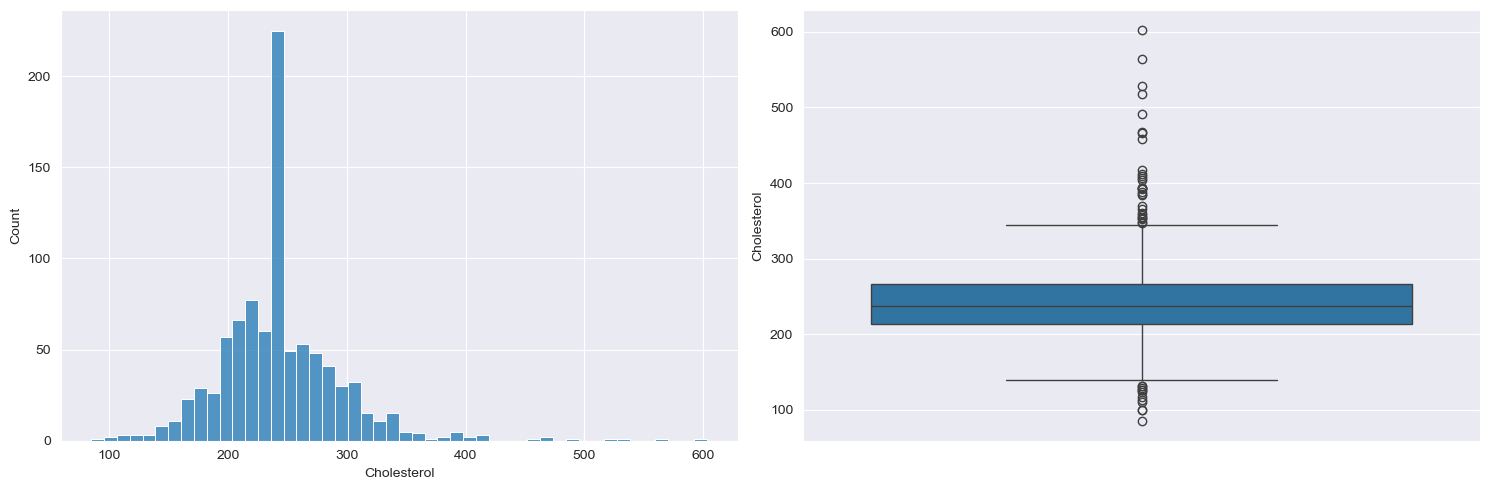

In [60]:
hist_box("Cholesterol", df_eda)

#### Analysis of `Cholesterol`

1.  **Initial Statistical Look:** The "before" plots and `describe()` summary showed a massive data integrity issue. A large number of rows (**172** in total) had a `Cholesterol` value of **0**.
2.  **Domain Knowledge Check:** A `Cholesterol` level of 0 is **physically impossible** and represents missing data or a data entry error ("trash"). This was further confirmed as the `mean` (198.8) was pulled significantly *below* the `median` (223.0) by these `0`s.
3.  **Decision & Action:**
    * Like `RestingBP`, a **targeted fix** was required. We could not remove these 172 rows without losing ~19% of our dataset.
    * We also could not leave the `0`s, as they would make all analysis (especially correlation) incorrect.
    * The **only** values replaced were the `0`s, which were first set to `np.nan` and then imputed using the dataset's **median** (223.0).
    * All valid high-value outliers (e.g., `603`) were **intentionally preserved** as they are clinically significant "treasure."
4.  **Conclusion:** The "after" plots show the `0` values are gone. This has created a large, **artificial spike** at the median (`223.0`). This is a known and accepted artifact of this "quick" imputation for EDA. It's a "lesser evil" that allows us to proceed with analysis, but we must remember that for *modeling*, a more advanced technique (like `KNNImputer`) would be preferable to avoid this spike.

### Oldpeak

In [61]:
lower, upper = IQR('Oldpeak', heart_data)
heart_data[(heart_data['Oldpeak'] < lower) | (heart_data['Oldpeak'] > upper)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
68,52,M,ASY,160,246,0,ST,82,Y,4.0,Flat,1
166,50,M,ASY,140,231,0,ST,140,Y,5.0,Flat,1
324,46,M,ASY,100,0,1,ST,133,N,-2.6,Flat,1
500,65,M,ASY,136,248,0,Normal,140,Y,4.0,Down,1
521,61,M,ASY,120,282,0,ST,135,Y,4.0,Down,1
537,74,M,ASY,150,258,1,ST,130,Y,4.0,Down,1
559,64,M,ASY,134,273,0,Normal,102,Y,4.0,Down,1
624,63,F,ASY,150,407,0,LVH,154,N,4.0,Flat,1
702,59,M,TA,178,270,0,LVH,145,N,4.2,Down,0
732,56,F,ASY,200,288,1,LVH,133,Y,4.0,Down,1


#### Analysis of `Oldpeak`

This feature is one of the most critical, and also one of the most complex.

1.  **Initial Statistical Look:** A `describe()` shows a `min` of **-2.6** and a `max` of **6.2**, with a median of 0.6.
2.  **Domain Knowledge Check:** Unlike `RestingBP` or `Cholesterol`, these extreme values are **not errors**.
    * `Oldpeak` measures the ST segment depression induced by exercise relative to rest.
    * **Positive values (`> 0`):** This indicates **ST Depression**. High values (like `4.0`, `6.2`) are a classic sign of severe ischemia (lack of blood flow). These are critical data points.
    * **Negative values (`< 0`):** This indicates **ST Elevation**. This is a rare but **extremely severe** clinical sign. It can point to an acute infarction (heart attack) or coronary artery spasm.

#### 🎯 Conclusion

The `Oldpeak` column contains **no impossible values** or "trash" data.

The negative values (`-2.6`, `-1.5`, etc.) and the high positive values (`6.2`, `5.0`, etc.) are arguably the **most important data points** in the dataset, representing the most severe cases.

**Decision:** This feature **will not be cleaned or altered**. It is ready for analysis as-is.

### MaxHR

In [62]:
lower, upper = IQR('MaxHR', heart_data)
heart_data[(heart_data['MaxHR'] < lower) | (heart_data['MaxHR'] > upper)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
370,60,M,ASY,135,0,0,Normal,63,Y,0.5,Up,1
390,51,M,ASY,140,0,0,Normal,60,N,0.0,Flat,1


#### Analysis of `MaxHR` (Maximum Heart Rate)

1.  **Statistical Look:** The data for `MaxHR` appears clean and robust. The `mean` (136.8) and `median` (138.0) are very close, indicating a symmetric, "bell-shaped" distribution with no significant skew from anomalies (unlike `Cholesterol`).
2.  **IQR Analysis:** An IQR analysis identified two statistical outliers on the low end: **60** and **63**.
3.  **Domain Knowledge Check:** These values are **not errors**. A `MaxHR` of 60 is physically possible, though extremely low for a stress test.
    * **Clinical Meaning:** This doesn't represent a data error (like `RestingBP = 0`), but rather a critical clinical finding. It likely signifies that the patient had extremely low exercise tolerance and the test was stopped immediately.
    * **Correlation:** A look at these two rows shows they both have `heartDisease = 1`. This suggests that an inability to raise one's heart rate during the test is a strong predictor of heart disease.

#### 🎯 Conclusion

The low `MaxHR` values are not "trash" but "treasure." They are valid, clinically significant data points.

**Decision:** This feature **will not be cleaned or altered**. It is ready for analysis as-is.